# Tutorial: Incorporating Symmetry into Deep Dynamics Models
(August 2023) Author: Rui Wang

# [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/iaifi/summer-school-2023/blob/main/Symmetry_Tutorial_Ray.ipynb)

This google colab tutorial is supporting material for the lectures by Robin Walters on *Incorporating Symmetry into Deep Dynamics Models* at [IAIFI Summer School](https://iaifi.org/phd-summer-school.html). We will 1) build regular group  convolution neural net layers; 2) define approximate equivariance and implement relaxed group convolution for translation group and C4 rotation group; 3) introduce basic ideas of steerable convolutions and [e2cnn](https://github.com/QUVA-Lab/e2cnn). 4) introduce several methods that can improve models' long-term dynmaics prediction accuracy.

This tutorial is based on the following materials:

* [Dr. Denis Boyda's tutorial](https://www.dropbox.com/sh/450ao3m5v4qt6o3/AABe1B2jEcyM5ZyoY_pmOStfa?dl=0) from IAIFI Summer School 2022.

* [UvA Deep Learning Tutorials](https://uvadlc-notebooks.readthedocs.io/en/latest/index.html).

* Prof. Erik Bekkers's course [Group Equivariant Deep Learning](https://www.youtube.com/@erikbekkers6398/videos).

* Cohen et al. [Group Equivariant Convolutional Networks](https://arxiv.org/pdf/1602.07576.pdf).

* Cohen et al. [Steerable CNNs](https://arxiv.org/abs/1612.08498).

* [E2CNN](https://github.com/QUVA-Lab/e2cnn) & [ESCNN](https://github.com/QUVA-Lab/escnn) & [E3NN](https://e3nn.org/)

* Wang and Walters et al. [Incorporating Symmetry into Deep Dynamics Models for Improved Generalization](https://arxiv.org/abs/2002.03061).

* Wang and Walters et al. [Approximately Equivariant Networks for Imperfectly Symmetric Dynamics](https://proceedings.mlr.press/v162/wang22aa.html).


# 1. Group Equivariant Convolutional Networks

## 1.1 Group, Equivariance and Group Equivariant Convolutional Networks

### 1.1.1 Definition of group

A Group (or Abstract group) $G = (\Omega, \cdot)$ is a set with a binary operation, called group multiplication, that satisfies the following four axioms:

1.   <ins>Closure</ins>: For any $g_1, g_2 \in G$ the product $g_1 \cdot g_2 = g_3 \in G$.
2.   <ins>Associativity</ins>: For any $g_1, g_2, g_3 \in G$: ($g_1 \cdot g_2) \cdot g_3 = g_1 \cdot (g_2 \cdot g_3)$.
3.   <ins>Identity</ins>: There exists an identity element $e$ s.t. $e \cdot g = g \cdot e = g$ for each $g \in G$.
4.   <ins>Inverse</ins>: For any $g \in G$ there exists an inverse element $g^{-1} \in G$, s.t. $g \cdot g^{-1} = e$.

E.g. Translation Group $(R^2, +)$ consists of all possible translations in $R^2$ and is equipped with group product and group inverse,

$$g \cdot g' = (x + x') ; \;\;\ g^{-1} = -x $$

with $g = (x), g' = (x')$ and $x, x' \in \mathbb{R}^2$.

E.g. Roto-translation group $SE(2) = \mathbb{R}^2 \rtimes SO(2)$ consists of the coupled space of translation vectors and rotations and is equipped with group product and group inverse,
$$g \cdot g' = (x, R_{\theta}) \cdot (x', R_{\theta'}) = (R_{\theta}x' + x, R_{\theta+\theta'}) ; \;\;\ g^{-1} = (-R_{\theta}^{-1}x, -R_{\theta}^{-1}) $$

with $g = (x, R_{\theta}), g' = (x', R_{\theta'})$.

### 1.1.2 Equivariance and Invariance

Formally, a function $f \colon X \to Y$ may be described as respecting the symmetry coming from a group $G$ using the notion of equivariance.  Assume a group representation $\rho_{\text{in}}$ of $G$ acts on $X$ and $\rho_{\text{out}}$ acts on $Y$. We say a function $f$ is <ins>$G$-equivariant</ins> if

$$ f( \rho_{\text{in}}(g)(x)) = \rho_{\text{out}}(g) f(x) $$
for all $x \in X$ and $g \in G$. The function $f$ is <ins>$G$-invariant</ins> if $f( \rho_{\text{out}}(g)(x)) = f(x)$ for all $x \in X$ and $g \in G$.  This is a special case of equivariance for the case $\rho_{\mathrm{out}}(g) = 1$.


![picture](https://drive.google.com/uc?export=view&id=1SVJOPGAzLo3D5BYdXT-uc5iGm1VLEAAE)

### 1.1.3 Recap on CNN

<ins>CNN is nothing else but group convolution with the translation group. </ins>

At each layer of a regular convnet convolves or correlates stack of feature maps $f : \mathbb{Z}^2 \rightarrow \mathbb{R}^K$ with a filter (or a set of filters) $\psi : \mathbb{Z}^2 \rightarrow \mathbb{R}^K$.


$$[f * \psi] (\mathbf{x}) = \sum_{\mathbf{y} \in \mathbb{Z}^2}f(\mathbf{y})\psi(\mathbf{y}-\mathbf{x}) = \sum_{\mathbf{y} \in \mathbb{Z}^2}f(\mathbf{y})T_{\mathbf{x}}\psi(\mathbf{y}) $$

A left regular representation is a representation that transforms the function $f$ by transforming their domains via inverse group actions.

### 1.1.4 Group Equivariant Convolution

<ins>G-CNN is a generalization of CNN for the case of an arbitrary group $G$.</ins>  

By replacing the shift with a more general transformation from some group $G$, We can make models become equivariant to other groups.

* The first layer of a G-CNN (Lifting Convolution): $$[f * \psi] (g) =  \sum_{\mathbf{y} \in \mathbb{Z}^2}f(\mathbf{y})\psi(g^{-1}\mathbf{y})$$

* For all layers after the first, both the input and the filters are functions on $G$:
$$[f * \psi] (g) =  \sum_{h \in G}f(h)\psi(g^{-1}h)$$

<ins>E.g.</ins> $G=\mathbb{Z}^2 \rtimes C_4$

* <ins>Lifting Convolution</ins> maps signals $f_{in}: \mathbb{Z}^2 → R$ to signals on arbitrary group G: $f_{out}: G→R$.  Group elements $g \in G = \mathbb{Z}^2 \rtimes C_4$ can be parametrized using $\mathbf{x} \in R^2$ and $r \in C_4$ such that $g=(\mathbf{x}, r)$. For such groups lifting convolution has form
$$
\begin{aligned}
f_{out}(\mathbf{x}, r) = (f_{in} * \psi) (\mathbf{x})
    &=
\sum_{\mathbf{y} \in \mathbb{Z}^2} f_{in}(\mathbf{y}) L_{r}  L_{\mathbf{x}} \psi(\mathbf{y}),\\
    &=
    \sum_{\mathbf{y} \in \mathbb{Z}^2}  f_{in}(\mathbf{y}) L_{r} \psi(\mathbf{y} -\mathbf{x}),\\
    &=
    \sum_{\mathbf{y} \in \mathbb{Z}^2}  f_{in}(\mathbf{y})\psi_{r}(\mathbf{y} -\mathbf{x}),\
\end{aligned}
$$
<ins>So lifting convolution is the same as conventional convolutions with a stack of filter bank </ins>$\{k_{r}(\mathbf{x})\}_{r \in C_4}$.

* <ins>Group Convolution:</ins> Note that the input feature map, $f_{in}$, now has one additional group dimension defined over $C_4$, besides the usual spatial dimensions defined over $\mathbb{R}^2$,

$$
\begin{aligned}
f_{out}(\mathbf{x}, r) = (f_{in} * \psi) (\mathbf{x}, r)
    &=
\sum_{\mathbf{y} \in \mathbb{Z}^2} \sum_{r' \in C^4} f_{in}(\mathbf{y} , r) L_{r} L_{\mathbf{x}} \psi(\mathbf{y},r'),\\
    &=
    \sum_{\mathbf{y} \in \mathbb{Z}^2} \sum_{r' \in C^4} f_{in}(\mathbf{y} , r')  L_{r} \psi(\mathbf{y-x},r'),\\
    &=
    \sum_{\mathbf{y} \in \mathbb{Z}^2} \sum_{r' \in C^4}  f_{in}(\mathbf{y}, r') \psi_r(\mathbf{y-x},r')\\
    &=
    \sum_{\mathbf{y} \in \mathbb{Z}^2} \sum_{r' \in C^4}  f_{in}(\mathbf{y}, r') \psi(r^{-1}(\mathbf{y-x}),r^{-1}r')\\
\end{aligned}
$$

## 1.2 C4 Cyclic Group

**Let's first implement a function that can rotate images**

In [11]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F

In [12]:
def rot_img(x, theta):
    """ Rotate 2D images
    Args:
        x : input images with shape [N, C, H, W]
        theta: angle
    Returns:
        rotated images
    """
    # Rotation Matrix (2 x 3)
    rot_mat = torch.FloatTensor([[np.cos(theta), -np.sin(theta), 0],
                                 [np.sin(theta), np.cos(theta), 0]])

    # The affine transformation matrices should have the shape of N x 2 x 3
    rot_mat = rot_mat.repeat(x.shape[0],1,1)

    # Obtain transformed grid
    # grid is the coordinates of pixels for rotated image
    # F.affine_grid assumes the origin is in the middle
    # and it rotates the positions of the coordinates
    # r(f(x)) = f(r^-1 x)
    grid = F.affine_grid(rot_mat, x.size(), align_corners=False).float()
    x = F.grid_sample(x, grid)
    return x.float()

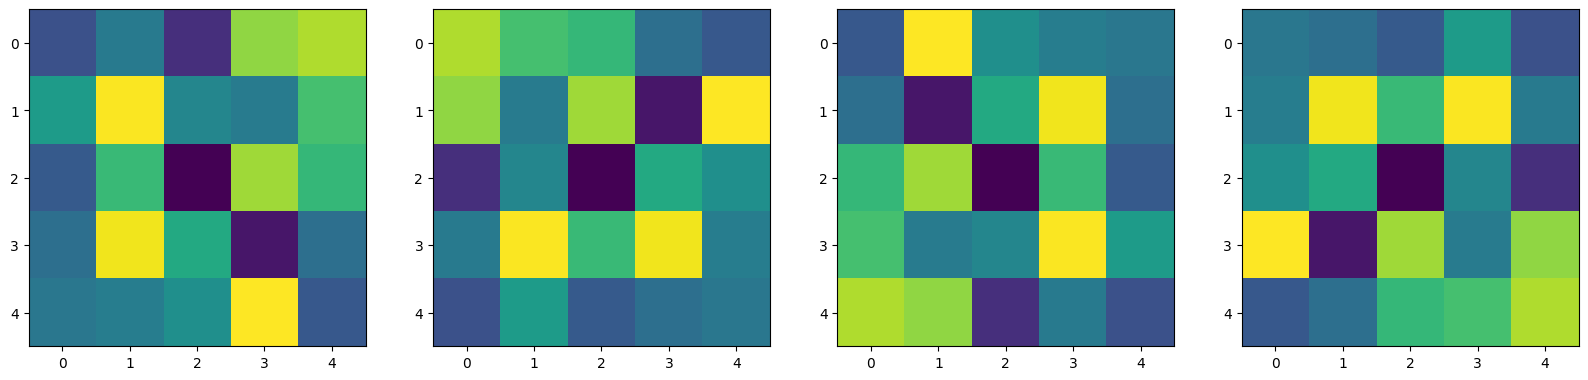

In [13]:
# C4 rotations: e, r, r^2, r^3
x = torch.rand(1,1,5,5)
fig=plt.figure(figsize=(20, 5))
for i in range(1, 5):
    fig.add_subplot(1, 4, i)
    plt.imshow(rot_img(x, np.pi/2*i)[0,0])
plt.show()

## 1.3 Implementing the Lift Convolution

$$f_{out}(\mathbf{x}, r) = (f_{in} * \psi) (\mathbf{x})
= \sum_{\mathbf{y} \in \mathbb{Z}^2}  f_{in}(\mathbf{y})\psi_{r}(\mathbf{y} -\mathbf{x})$$

**In lift convolution, the input convolves with a stack of rotated filters.**

*The reason why we call it lifting is that we add a new axis $r$ in the output feature maps.*

![picture](https://drive.google.com/uc?export=view&id=17RprAkuSe43q_gjsi1al2RX18mZ0o00q)

In [14]:
class LiftingConvolution(nn.Module):
    """Lifting Convolution Layer for finite rotation group

    Attributes:
        in_channels: number of input channels
        out_channels: number of output channels
        kernel_size: kernel size
        group_order: the order of rotation groups
        activation: whether to use relu.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 group_order,
                 activation = True
                 ):
        super(LiftingConvolution, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.group_order = group_order
        self.activation = activation

        # Initialize an unconstrained kernel.
        self.weight = torch.nn.Parameter(torch.zeros(self.out_channels,
                                                     self.in_channels,
                                                     self.kernel_size,
                                                     self.kernel_size))

        # Initialize weights
        stdv = np.sqrt(1/(self.in_channels*self.kernel_size*self.kernel_size))
        self.weight.data.uniform_(-stdv, stdv)

    def generate_filter_bank(self):
        # Obtain a stack of rotated filters
        # Rotate kernels by 0, 90, 180, and 270 degrees
        # ==============================
        filter_bank = torch.stack([rot_img(self.weight, -np.pi*2/self.group_order*i)
                                   for i in range(self.group_order)])
        # ==============================

        # [#out, group_order, #in, k, k]
        filter_bank = filter_bank.transpose(0,1)
        return filter_bank


    def forward(self, x):
        # input shape: [bz, #in, h, w]
        # output shape: [bz, #out, group order, h, w]

        # generate filter bank given input group order
        filter_bank = self.generate_filter_bank()

        # concatenate the first two dims before convolution.
        # ==============================
        x = F.conv2d(
            input=x,
            weight=filter_bank.reshape(
                self.out_channels * self.group_order,
                self.in_channels,
                self.kernel_size,
                self.kernel_size
            ),
            padding = (self.kernel_size-1)//2
        )
        # ==============================

        # reshape output signal to shape [bz, #out, group order, h, w].
        # ==============================
        x = x.view(
            x.shape[0],
            self.out_channels,
            self.group_order,
            x.shape[-1],
            x.shape[-2]
        )
        # ==============================
        if self.activation:
            return F.relu(x)
        return x

In [15]:
lifting_layer = LiftingConvolution(in_channels = 1,
                                   out_channels = 1,
                                   kernel_size = 3,
                                   group_order = 4,
                                   activation = True)

x = torch.rand(1, 1, 64, 64)
out = lifting_layer(x)
print(out.shape)

torch.Size([1, 1, 4, 64, 64])


## 1.4 Implementing Group Convolution Kernel

**After the first layer, both the filter and input are now functions on $G=\mathbb{Z}^2 \rtimes C_4$**

*Be careful about this, rotation not only acts on the spatial dimension but also the new $r$ axis. A rotation means a planar rotation and periodic shft.*

*A single channel from regular CNNs is expanded to four channels since we apply kernel with rotations four times.*

$$f_{out}(\mathbf{x}, r) = (f_{in} * \psi) (\mathbf{x}, r)
    = \sum_{\mathbf{y} \in \mathbb{Z}^2} \sum_{r' \in C^4}  f_{in}(\mathbf{y}, r') \psi(r^{-1}(\mathbf{y-x}),r^{-1}r')
$$


![picture](https://drive.google.com/uc?export=view&id=1ADYVLN8veOHRgK_l50p7Vw3-Nvn2E0P9)


In [16]:
class GroupConvolution(nn.Module):
    """Group Convolution Layer for finite rotation group

    Attributes:
        in_channels: number of input channels
        out_channels: number of output channels
        kernel_size: kernel size
        group_order: the order of rotation groups
        activation: whether to use relu.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 group_order,
                 activation = True,
                 ):
        super(GroupConvolution, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.group_order = group_order
        self.activation = activation

        # Initialize an unconstrained kernel.
        # the weights have an additional group order dimension.
        self.weight = torch.nn.Parameter(torch.zeros(self.out_channels,
                                                     self.in_channels,
                                                     self.group_order, # this is different from the lifting convolution
                                                     self.kernel_size,
                                                     self.kernel_size))

        stdv = np.sqrt(1/(self.in_channels*self.kernel_size*self.kernel_size))
        self.weight.data.uniform_(-stdv, stdv)

    def generate_filter_bank(self):
        # Obtain a stack of rotated and cyclic shifted filters
        filter_bank = []
        weights = self.weight.reshape(self.out_channels*self.in_channels,
                                     self.group_order,
                                     self.kernel_size,
                                     self.kernel_size)

        for i in range(self.group_order):
            # planar rotation
            rotated_filter = rot_img(weights, -np.pi*2/self.group_order*i)

            # cyclic shift
            shifted_indices = torch.roll(torch.arange(0, self.group_order, 1), shifts = i)
            shifted_rotated_filter = rotated_filter[:,shifted_indices]


            filter_bank.append(shifted_rotated_filter.reshape(self.out_channels,
                                                            self.in_channels,
                                                            self.group_order,
                                                            self.kernel_size,
                                                            self.kernel_size))
        # stack
        # reshape output signal to shape [#out, g_order, #in, g_order, k, k].
        filter_bank = torch.stack(filter_bank).transpose(0,1)
        return filter_bank

    def forward(self, x):
        # input shape: [bz, in, group order, x, y]
        # output shape: [bz, out, group order, x, y]

        # Generate filter bank with shape [#out, g_order, #in, g_order, h, w]
        filter_bank = self.generate_filter_bank()

        # Reshape filter_bank to use F.conv2d
        # [#out, g_order, #in, g_order, h, w] -> [#out*g_order, #in*g_order, h, w]
        # ==============================
        x = torch.nn.functional.conv2d(
            input=x.reshape(
                x.shape[0],
                x.shape[1] * x.shape[2],
                x.shape[3],
                x.shape[4]
                ),
            weight=filter_bank.reshape(
                self.out_channels * self.group_order,
                self.in_channels * self.group_order,
                self.kernel_size,
                self.kernel_size
            ),
            padding = (self.kernel_size-1)//2
        )

        # Reshape signal back [bz, #out * g_order, h, w] -> [bz, out, g_order, h, w]
        x = x.view(x.shape[0], self.out_channels, self.group_order, x.shape[-2], x.shape[-1])
        # ========================

        if self.activation:
          return F.relu(x)
        return x

In [17]:
groupconv_layer = GroupConvolution(in_channels = 1,
                                   out_channels = 1,
                                   kernel_size = 5,
                                   group_order = 4,
                                   activation = True)
# The input has an additional dimension.
x = torch.rand(1, 1, 4, 64, 64)
out = groupconv_layer(x)
print(out.shape)

torch.Size([1, 1, 4, 64, 64])


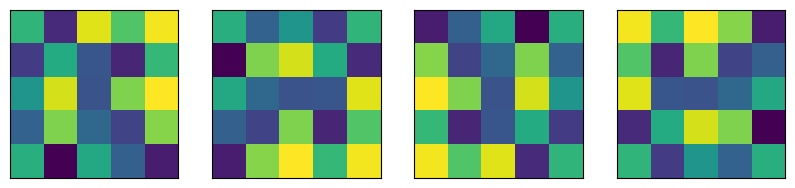

In [18]:
# C4 rotations: e, r, r^2, r^3
filter_bank = groupconv_layer.generate_filter_bank()
fig=plt.figure(figsize=(10, 5))
i = 4
for j in range(1, 5):
    fig.add_subplot(1, 4, j)
    plt.imshow(filter_bank[0,j-1,0,j-1].data.numpy())
    plt.xticks([])
    plt.yticks([])

## 1.5 Test Equivariance

$$ \|f\|_{EE} = sup_{x,g}\|f(\rho_X(g)x) - \rho_Y(g)f(x)\| = 0$$

**Let's build a group equivariant CNNs.**

In [26]:
class GroupEquivariantCNN(torch.nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 hidden_dim,
                 group_order,
                 num_gconvs # number of group convolution layers.
                 ):
        super().__init__()

        # First Layer
        self.lifting_conv = LiftingConvolution(in_channels = in_channels,
                                               out_channels = hidden_dim,
                                               kernel_size = kernel_size,
                                               group_order = group_order,
                                               activation = True)
        # Middle Layers
        self.gconvs = []
        for i in range(num_gconvs):
            self.gconvs.append(GroupConvolution(in_channels = hidden_dim,
                                                out_channels = hidden_dim,
                                                kernel_size = kernel_size,
                                                group_order = group_order,
                                                activation = True))
        self.gconvs = nn.Sequential(*self.gconvs)


        # Final Layer
        # To generate equivariant outputs
        self.final_layer = GroupConvolution(in_channels = hidden_dim,
                                            out_channels = out_channels,
                                            kernel_size = kernel_size,
                                            group_order = group_order,
                                            activation = False)


    def forward(self, x):
        out = self.lifting_conv(x)

        out = self.gconvs(out)

        # functions on (g,x,y) -> functions on (x,y)
        out = torch.mean(self.final_layer(out), dim = 2)

        # If we want to have a invariant classifer, we can average over the last three dimensions.
        # out = F.sigmoid(torch.mean(self.final_layer(out), dim = (2,3,4)))
        return out

In [20]:
GCNN = GroupEquivariantCNN(in_channels = 1,
                           out_channels = 1,
                           kernel_size = 3,
                           hidden_dim = 4,
                           group_order = 4,
                           num_gconvs = 1)

Test whether the model is equivariant under C4 transformations.

In [ ]:
# Download mnist dataset.
train_ds = torchvision.datasets.MNIST(root="data", train=True, download=True)
image = torch.from_numpy(train_ds.data[0].numpy()).unsqueeze(0).unsqueeze(0).float()
image = (image - image.min())/(image.max() - image.min())


## |rf(x) - f(rx)|
# test whether the model is equivariant under C4 transformations.
for i in range(4):
    theta = np.pi/2*i
    x = image
    f_x = GCNN(x)
    r_f_x = rot_img(f_x, theta).data.numpy()
    r_x = rot_img(x, theta)
    f_r_x = GCNN(r_x).data.numpy()

    equiv_error = np.mean(np.abs(r_f_x - f_r_x))
    print("Equivariance Error with Rotation {:0.0f} Degrees: {:0.5f}".format(theta/np.pi/2*360, equiv_error))



We can also visualize $f(rx)$ and $r(f(x))$ and compare them.

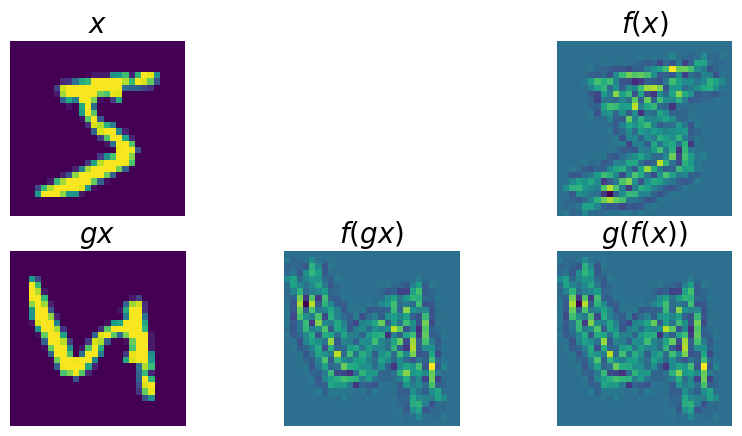

In [22]:
titles = ["$x$", "$f(x)$", "$gx$", "$f(gx)$", "$g(f(x))$"]
vis_imgs = [x[0,0], f_x[0,0].data.numpy(), r_x[0,0].data.numpy(), f_r_x[0,0], r_f_x[0,0]]
fig=plt.figure(figsize=(10, 5))
idx = 0
for i in range(6):
    if i == 1:
        continue
    fig.add_subplot(2, 3, i+1)
    plt.imshow(vis_imgs[idx])
    plt.title(titles[idx], fontsize = 20)
    plt.axis('off')
    idx += 1
plt.show()

# 2.  Approximately Equivariant Networks

### 2.1.1 Situations where perfectly equivariant models may not work

**1) If the image of 6 is perfectly rotated version of 9, Can GCNN distinguish them?**

In [25]:
x_6, x_9 = np.zeros((16, 16)), np.zeros((16, 16))
points_6 = [(5, 5),(5, 6),(5, 7),(5, 8),(5, 9),(5, 10),
            (6, 5),(6, 10),(7, 5),(7, 10),(8, 5),(8, 6),
            (8, 7),(8, 8),(8, 9),(8, 10),(9, 5),(10, 5),
            (11, 5),(11, 6),(11, 7),(11, 8),(11, 9),(11, 10)]

points_9 = [(4, 5),(4, 6),(4, 7),(4, 8),(4, 9),(4, 10),(5, 10),
            (6, 10),(7, 5),(7, 6),(7, 7),(7, 8),(7, 9),(7, 10),
            (8, 5),(8, 10),(9, 5),(9, 10),(10, 5),(10, 6),(10, 7),
            (10, 8),(10, 9),(10, 10)]
for x,y in points_6:
    x_6[x,y] = 1.0
for x,y in points_9:
    x_9[x,y] = 1.0
# plt.imshow(x_6, origin="lower")

**Let's train a GCNN classifier (modify the last layer the GroupEquivariantCNN in 1.5 first)**

*You'll see the loss doesn't converge because the C4-GCNN can't distinguish these two digits.*

In [ ]:
GCNN = GroupEquivariantCNN(in_channels = 1,
                           out_channels = 1,
                           kernel_size = 3,
                           hidden_dim = 4,
                           group_order = 4,
                           num_gconvs = 1)

# image 6 and 9
inps = torch.stack([torch.from_numpy(x_6), torch.from_numpy(x_9)]).unsqueeze(1).float()

# labels
tgts = torch.FloatTensor([0,1])

loss_fun = nn.BCELoss()
optimizer = optim.Adam(GCNN.parameters(), lr=0.001)


for epoch in range(1000):
    # forward + backward + optimize
    outputs = GCNN(inps)
    loss = loss_fun(outputs[:,0], tgts)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print statistics
    if epoch % 100 == 0:
        print("Epoch: {} | Loss: {:0.5f} ".format(epoch,  loss.item()))


2) Real-world dynamics data may not satisfy the strict equivariance.  

*Wang and Walters et al. [Approximately Equivariant Networks for Imperfectly Symmetric Dynamics](https://proceedings.mlr.press/v162/wang22aa.html).*

3) When the outputs have lower symmetry than input.

*Smidt et al. [Finding Symmetry Breaking Order Parameters with Euclidean Neural Networks](https://arxiv.org/abs/2007.02005)*

![picture](https://drive.google.com/uc?export=view&id=1wtUfmwYxVxp_VcUfa3GRaRgxELS-Degg)

Other relevant papers:
* Finzi et al. [Residual Pathway Priors for Soft Equivariance Constraints](https://arxiv.org/abs/2112.01388)
* Elsayed et al. [Revisiting Spatial Invariance with Low-Rank Local Connectivity](https://arxiv.org/abs/2002.02959)

### 2.1.2 Approximate Equivariance
Let $f \colon X \to Y$ be a function and $G$ be a group. Assume that $G$ acts on $X$ and $Y$ via representations $\rho_{X}$ and $\rho_{Y}$. We say $f$ is $\epsilon$-approximately $G$-equivariant if for any $g \in G$,

$$ \|f(\rho_{X}(g)(x)) - \rho_{Y}(g)f(x)\| \leq \epsilon. $$

Note that strictly equivariant functions are $\epsilon = 0$ approximately equivariant.

### 2.1.3 Relaxed Group Convolution

**We relax the weight-sharing constraints in Equivariant Networks by introducing group element dependent parameters.**

Group Convolution: $$[f * \psi] (g) =  \sum_{h \in G}f(h)\psi(g^{-1} h)$$
The $G$-equivariance of group convolution results from the shared kernel $\psi(g^{-1}h)$.  To relax this and consequently relax the $G$-equivariance, we replace the single kernel $\psi$ with a set of kernels $\lbrace \psi_l \rbrace_{l=1}^L$. We define the new kernel $\psi$ as a linear combination of $\psi_l$ with coefficients that vary with $h$ and thus introduce symmetry-breaking dependence on the specific pair $(g,h)$,

$$ \psi(g,h) = \sum_{l=1}^L w_l(h) \psi_l(g^{-1}h). $$
We define relaxed group convolution by multiplication with $\psi$ as such

$$[f {\Large\star} \psi](g) = \sum_{h\in G}f(h)\psi(g, h)
  = \sum_{h\in G}\sum_{l=1}^L f(h) w_l(h) \psi_l(g^{-1}h) $$

By varying the number of kernels $L$, we can control the degree of relaxation of equivariance. The weights $w_i(h) \in \mathbb{R}$ and the kernels $\psi_l(g^{-1}h) \in \mathbb{R}^{c_\mathrm{out} \times c_\mathrm{in}}$ can be learnt from data.  Relaxed group convolution reduces to group convolution and is fully equivariant if and only if $g_1^{-1}h_1 = g_2^{-1} h_2$ implies $\psi(g_1,h_1) = \psi(g_2,h_2)$.  In particular, this occurs if $w_l(h_1) =  w_l(h_2)$ for all $h_1,h_2 \in G$ and for all $l$.

e.g. To relax translation equivariance, instead of using a single filter, we use a linear combination of multiple filters where the coefficients can be varying across the input location.

![picture](https://drive.google.com/uc?export=view&id=1oNcmOFXuedlOkX-rQ8Pq4_fssEw4TOCm)


## 2.2 Implementing Relaxed Translation Equivariant Layers

In [30]:
class Relaxed_ConvBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 h_size, # Image size
                 w_size,
                 num_filter_banks # L
                ):

        super(Relaxed_ConvBlock, self).__init__()

        # Initialize multiple filters.
        self.convs = nn.Sequential(*[nn.Conv2d(in_channels,
                                               out_channels,
                                               kernel_size,
                                               padding=(kernel_size-1)//2)
                                     for i in range(num_filter_banks)])
        self.num_filter_banks = num_filter_banks

        # For every location we initialize a set of coefficients for linear combinations.
        self.combination_weights = nn.Parameter(torch.ones(h_size, w_size, num_filter_banks).float()/num_filter_banks)
        self.activation = nn.ReLU()

    def forward(self, x):
        # Compute Convolution for each filter
        outs = torch.stack([self.convs[i](x) for i in range(self.num_filter_banks)], dim  = 0)

        # Compute the linear combination of kernels for each spatial location
        out = torch.einsum("ijr, rboij -> boij", self.combination_weights, outs)
        return self.activation(out)

In [31]:
model = Relaxed_ConvBlock(in_channels = 1,
                          out_channels = 1,
                          kernel_size = 3,
                          h_size = 64,
                          w_size = 64,
                          num_filter_banks = 3)

out = model(torch.randn(8, 1, 64, 64))
out.shape

torch.Size([8, 1, 64, 64])

## 2.4 Implementing Relaxed Rotaion Equivariant Layers

In [32]:
class Relaxed_LiftingConvolution(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 group_order,
                 num_filter_banks,
                 activation = True
                 ):
        super(Relaxed_LiftingConvolution, self).__init__()

        self.num_filter_banks = num_filter_banks
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.group_order = group_order
        self.activation = activation

        self.combination_weights = nn.Parameter(torch.ones(num_filter_banks, group_order).float()/num_filter_banks)

        # Initialize an unconstrained kernel.
        self.weight = torch.nn.Parameter(torch.zeros(self.num_filter_banks, # Additional dimension
                                                     self.out_channels,
                                                     self.in_channels,
                                                     self.kernel_size,
                                                     self.kernel_size))
        stdv = np.sqrt(1/(self.in_channels*self.kernel_size*self.kernel_size))
        self.weight.data.uniform_(-stdv, stdv)

        # If combination_weights are equal values, then the model is still equivariant
        # self.combination_weights.data.uniform_(-stdv, stdv)

    def generate_filter_bank(self):
        """ Obtain a stack of rotated filters"""
        weights = self.weight.reshape(self.num_filter_banks*self.out_channels,
                                      self.in_channels,
                                      self.kernel_size,
                                      self.kernel_size)
        filter_bank = torch.stack([rot_img(weights, -np.pi*2/self.group_order*i)
                                   for i in range(self.group_order)])
        filter_bank = filter_bank.transpose(0,1).reshape(self.num_filter_banks, # Additional dimension
                                                         self.out_channels,
                                                         self.group_order,
                                                         self.in_channels,
                                                         self.kernel_size,
                                                         self.kernel_size)
        return filter_bank


    def forward(self, x):
        # input shape: [bz, #in, h, w]
        # output shape: [bz, #out, group order, h, w]

        # generate filter bank given input group order
        filter_bank = self.generate_filter_bank()

        # for each rotation, we have a linear combination of multiple filters with different coefficients.
        relaxed_conv_weights = torch.einsum("na, noa... -> oa...", self.combination_weights, filter_bank)

        # concatenate the first two dims before convolution.
        # ==============================
        x = F.conv2d(
            input=x,
            weight=relaxed_conv_weights.reshape(
                self.out_channels * self.group_order,
                self.in_channels,
                self.kernel_size,
                self.kernel_size
            ),
            padding = (self.kernel_size-1)//2
        )
        # ==============================

        # reshape output signal to shape [bz, #out, group order, h, w].
        # ==============================
        x = x.view(
            x.shape[0],
            self.out_channels,
            self.group_order,
            x.shape[-1],
            x.shape[-2]
        )
        # ==============================

        if self.activation:
            return F.relu(x)
        return x

In [37]:
class Relaxed_GroupConv(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 group_order,
                 num_filter_banks,
                 activation = True
                ):

        super(Relaxed_GroupConv, self).__init__()

        self.num_filter_banks = num_filter_banks
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.group_order = group_order
        self.activation = activation


        ## Initialize weights
        self.combination_weights = nn.Parameter(torch.ones(group_order, num_filter_banks).float()/num_filter_banks)
        self.weight = nn.Parameter(torch.randn(self.num_filter_banks, ##additional dimension
                                               self.out_channels,
                                               self.in_channels,
                                               self.group_order,
                                               self.kernel_size,
                                               self.kernel_size))

        stdv = np.sqrt(1/(self.in_channels))
        self.weight.data.uniform_(-stdv, stdv)

        # If combination_weights are equal values, then the model is still equivariant
        # self.combination_weights.data.uniform_(-stdv, stdv)


    def generate_filter_bank(self):
        """ Obtain a stack of rotated and cyclic shifted filters"""
        filter_bank = []
        weights = self.weight.reshape(self.num_filter_banks*self.out_channels*self.in_channels,
                                      self.group_order,
                                      self.kernel_size,
                                      self.kernel_size)

        for i in range(self.group_order):
            # planar rotation
            rotated_filter = rot_img(weights, -np.pi*2/self.group_order*i)

            # cyclic shift
            shifted_indices = torch.roll(torch.arange(0, self.group_order, 1), shifts = i)
            shifted_rotated_filter = rotated_filter[:,shifted_indices]


            filter_bank.append(shifted_rotated_filter.reshape(self.num_filter_banks,
                                                              self.out_channels,
                                                              self.in_channels,
                                                              self.group_order,
                                                              self.kernel_size,
                                                              self.kernel_size))
        # stack
        filter_bank = torch.stack(filter_bank).permute(1,2,0,3,4,5,6)
        return filter_bank

    def forward(self, x):

        filter_bank = self.generate_filter_bank()

        relaxed_conv_weights = torch.einsum("na, aon... -> on...", self.combination_weights, filter_bank)

        x = torch.nn.functional.conv2d(
            input=x.reshape(
                x.shape[0],
                x.shape[1] * x.shape[2],
                x.shape[3],
                x.shape[4]
                ),
            weight=relaxed_conv_weights.reshape(
                self.out_channels * self.group_order,
                self.in_channels * self.group_order,
                self.kernel_size,
                self.kernel_size
            ),
            padding = (self.kernel_size-1)//2
        )

                # Reshape signal back [bz, #out * g_order, h, w] -> [bz, out, g_order, h, w]
        x = x.view(x.shape[0], self.out_channels, self.group_order, x.shape[-2], x.shape[-1])
        # ========================

        return x

class RelaxedGroupEquivariantCNN(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, hidden_dim, group_order, num_gconvs):
        super().__init__()

        # First Layer
        self.lifting_conv = Relaxed_LiftingConvolution(in_channels = in_channels,
                                                       out_channels = hidden_dim,
                                                       kernel_size = kernel_size,
                                                       group_order = group_order,
                                                       num_filter_banks = 3,
                                                       activation = True)
        # Middle Layer
        self.gconvs = []
        for i in range(num_gconvs):
            self.gconvs.append(Relaxed_GroupConv(in_channels = hidden_dim,
                                                out_channels = hidden_dim,
                                                kernel_size = kernel_size,
                                                group_order = group_order,
                                                num_filter_banks = 3,
                                                activation = True))

        self.gconvs = nn.Sequential(*self.gconvs)


        # Final Layer
        self.final_layer = Relaxed_GroupConv(in_channels = hidden_dim,
                                            out_channels = out_channels,
                                            kernel_size = kernel_size,
                                            group_order = group_order,
                                            num_filter_banks = 3,
                                            activation = False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.lifting_conv(x)

        out = self.gconvs(out)

        # Generate a image output
        out = torch.mean(self.final_layer(out), dim = 2)
        return out

        # Generate a class probability
        # out = torch.mean(self.final_layer(out), dim = (2,3,4))
        # return self.sigmoid(out)

Relaxed_GCNN = RelaxedGroupEquivariantCNN(in_channels = 1,
                                          out_channels = 1,
                                          kernel_size = 3,
                                          hidden_dim = 4,
                                          group_order = 4,
                                          num_gconvs = 1)

In [ ]:
# Download a single sample from mnist.
# train_ds = torchvision.datasets.MNIST(root="data", train=True, download=True)
# image = torch.from_numpy(train_ds.data[0].numpy()).unsqueeze(0).unsqueeze(0).float()
# image = (image - image.min())/(image.max() - image.min())

## |rf(x) - f(rx)|
for i in range(4):
    theta = np.pi/2*i
    x = image
    f_x = Relaxed_GCNN(x)
    r_f_x = rot_img(f_x, theta).data.numpy()
    r_x = rot_img(x, theta)
    f_r_x = Relaxed_GCNN(r_x).data.numpy()

    equiv_error = np.mean(np.abs(r_f_x - f_r_x))
    print("Equivariance Error with Rotation {:0.0f} Degrees: {:0.4f}".format(theta/np.pi/2*360, equiv_error))

**Exercise: let's train a Relaxed GCNN classifier to distinguish image 9 and 6. Does the loss converge?**

# 3. Steerable CNNs

## 3.1 Representation and Steerable Convolution

### 3.1.1 Representation

A **linear group representation** $\rho$ of a compact group $G$ on a vector space (called *representation space*) $\mathbb{R}^d$ is a *group homomorphism* from $G$ to the general linear group $GL(\mathbb{R}^d)$, i.e. it is a map $\rho : G \to \mathbb{R}^{d \times d}$ such that:
$$\rho(g_1 g_2) = \rho(g_1) \rho(g_2) \quad \forall g_1,g_2 \in G \ .$$

In other words, $\rho(g)$ is a $d \times d$ *invertible* matrix.
We refer to $d$ as the *size* of the representation.

### 3.1.2 Trivial Representation $\rho_0$

The simplest example of *group representation* is the **trivial representation** which maps every element to $1 \in \mathbb{R}$, i.e. $\rho: g \mapsto 1$.

### 3.1.3 Two-dimensional Representaion $\rho_1$

As we know cyclic group $C_4$ is a discretization of a group of all planar rotations by an arbitrary angle, $SO(2)$. Rotation of a vector $\mathbf{x} \in R^2$ by arbitrary angle $\theta$ is defined by multiplication with a matrix $\rho_1(\theta)$:

$$
    \rho_2(\theta) = \begin{bmatrix} \cos(\theta) & -\sin(\theta) \\ \sin(\theta) & \cos(\theta) \end{bmatrix}.
$$

For $C_4$, we have only four different matrixes.

### 3.1.4 Regular Representation

A commonly used representation in equivariant deep
learning is the regular representation. The regular representation of a finite group $G$ acts on a vector
space $\mathbb{R}^{|G|}$ by permuting its axes.

Specifically, associating each axis $e_g$ of $\mathbb{R}^{|G|}$ to an element $g \in G$, the representation of an element $g^* \in G$ is a permutation matrix which maps $e_g$ to $e_{g^* g}$.

For instance, the regular representation of the group C4 with elements $\{p \frac{\pi}{2}|p = 0, . . . , 3\}$ is instantiated by:

![picture](https://drive.google.com/uc?export=view&id=1cuAVAE6sFeppk5-bxHsymoo83URqetlv)

*The Group Convolution feature maps can be considered as feature fields. For every position, we have a fiber and these signals are represented by regular representations.*

### 3.1.5 Induced Representation

We call $f:\mathbb{R}^d → \mathbb{R}^{d_{\rho}}$ a feature vector field, or simply a **feature field**, if its

1) *codomain* transform via a representation $\rho(h)$ of a group $H$

2) *domain* transform via the action $g^{-1}$ of $G = (\mathbb{R}^d, +) \rtimes H$

Representation $\rho$ defines the type of the field, and together with the group action of $G = (\mathbb{R}^d, +) \rtimes H$ defines the ***induced representation***

$$(Ind_H^G[\rho](\textbf{x}, h)f)(\textbf{x}')= \rho(h)f(h^{-1}(\textbf{x}'-\textbf{x}))$$

*For example, consider an image as network input. A rotation of a gray-scale image is performed by moving each pixel to a new position. The invariance of the scalar pixel values under rotations is modeled by the **trivial representation** $\rho:G\to\operatorname{GL}(1),\ g\mapsto(1)$ of $G$ and identifies them as **scalar fields**.*

*Formally, a scalar field is a function $f: \mathbb{R}^2 \to \mathbb{R}$ mapping to a feature vector with $c=1$ channels.
A rotation by an angle $\theta \in C_4$ transforms this scalar field as*
$$ \big[R_{\theta}\, f\big](x)
   \ :=\ \rho(\theta)\,f\big(R^{-1} x\big)
   \ =\ 1\cdot f\big(R^{-1}x\big)
   \ =\ f\big(R^{-1}x\big),$$

**But when rotating vector field, each vector is not only moved to a new position but additionally changes its
orientation via the action $g \in G$**

**Download ocean current data from [here](https://drive.google.com/file/d/1F7-XUAOYxD2g1PNDmq-QrtTnHb9vr1ey/view?usp=sharing) or creat a random vector field**

In [41]:
# The file contains 10 steps of ocean current velocity fields from Atlantic Ocean
ocean_sample = torch.load("ocean_atlantic_sample.pt").numpy()
ocean_sample.shape

(10, 2, 253, 253)

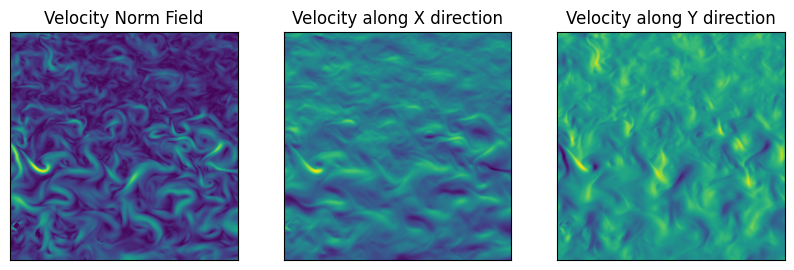

In [42]:
ocean_sample = ocean_sample[0]
fig=plt.figure(figsize=(10, 5))
imgs = [np.sqrt(ocean_sample[0]**2 + ocean_sample[1]**2), ocean_sample[0], ocean_sample[1]]
titles = ["Velocity Norm Field", "Velocity along X direction", "Velocity along Y direction"]
for i in range(3):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(imgs[i])
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
plt.show()


 A function that helps visualize vector field

In [ ]:
#  A function that helps visualize vector field
def visualize_vector_field(vector_field, scale = 100):
    # Input vector field must have shape (H, W, 2) or (2, H, W).
    assert len(vector_field.shape) == 3
    if vector_field.shape[0] == 2:
        vector_field = vector_field.transpose(1,2,0)

    H, W, _ = vector_field.shape
    x_coords, y_coords = np.mgrid[0:H, 0:W]

    # Extract the x and y components of the vector field
    u = vector_field[:, :, 0]
    v = vector_field[:, :, 1]

    # Create a quiver plot with blue arrows, without axes and labels
    plt.quiver(x_coords, y_coords, u, v, color='blue', scale=scale)
    plt.axis('off')

    # Show the plot
    plt.show()

# Let's just look at a small patch of it
small_ocean_sample = ocean_sample[:, :16, :16]
visualize_vector_field(small_ocean_sample, scale = 10)


If we only rotate the positions of vectors

In [ ]:
rot_pos_sample = rot_img(torch.from_numpy(small_ocean_sample).unsqueeze(0).float(), np.pi/2).squeeze(0)
visualize_vector_field(rot_pos_sample.data.numpy(), scale = 10)

We also need to rotate the orientation of the vectors

In [ ]:
def rot_vector(x, theta):
    #x has the shape [c x 2 x h x w]
    rho = torch.FloatTensor([[np.cos(theta), -np.sin(theta)],
                             [np.sin(theta), np.cos(theta)]])
    out = torch.einsum("ab, bc... -> ac...",(rho, x.transpose(0,1))).transpose(0,1)
    return out


rot_direc_pos_sample = rot_vector(rot_pos_sample.unsqueeze(0), np.pi/2).squeeze(0)
visualize_vector_field(rot_direc_pos_sample.data.numpy(), scale = 10)


### 3.1.6 Steerable Constraint

Let $f$ be the input feature map $f \colon \mathbb{R}^2 \to \mathbb{R}^{c_\mathrm{in}}$ with group $G \subset O(2)$ acting on
$\mathbb{R}^2$ by matrix multiplication and on the channel space $\mathbb{R}^{c_\mathrm{in}}$ by $\rho_{\mathrm{in}}$.  Also fix an $G$-action $\rho_{\mathrm{out}}$ on $\mathbb{R}^{c_\mathrm{out}}$.  Let $\phi \colon \mathbb{R}^2 \to \mathbb{R}^{c_\mathrm{out} \times c_\mathrm{in}}$ be a kernel, then the standard 2D convolution $f *_{\mathbb{R}^2} \phi$ is $G$-equivariant and $\mathbb{R}^2$-translation equivariant when

$$\phi(gx) = \rho_{\text{out}}(g) \phi(x) \rho_{\text{in}}(g^{-1})\ \forall g \in G. $$

Given $\rho_\text{in}$ and $\rho_\text{out}$, we can compute a basis for such linear space by solving a linear system. Once we have such a basis, we can express any equivariant filter bank as a linear combination with trainable coefficients: $\phi = \sum_{l=1}^L w_l \phi_l$.

**Proof:** If $\phi$ satisfies the steerabile constraint then

$$
\begin{align}
    \phi \star [g \cdot f_\text{in}](\mathbf{y})
    &= \int_{\mathbb{R}^2} \phi(\mathbf{x}-\mathbf{y}) [g \cdot f_\text{in}](\mathbf{x}) d\mathbf{x} \\
    &= \int_{\mathbb{R}^2} \phi(\mathbf{x}-\mathbf{y}) \rho_\text{in}(g)f_\text{in}(g^{-1}\mathbf{x}) d\mathbf{x} \\
    &= \int_{\mathbb{R}^2} \rho_{\text{out}}(g) \phi(g^{-1}(\mathbf{x}-\mathbf{y})) \rho_{\text{in}}(g^{-1}) \rho_\text{in}(g)f_\text{in}(g^{-1}\mathbf{x}) d\mathbf{x} \\
    &= \rho_\text{out}(g) \int_{\mathbb{R}^2} \phi(g^{-1}\cdot(\mathbf{x}-\mathbf{y}))f_\text{in}(g^{-1}\mathbf{x}) d\mathbf{x} \\
    &= \rho_\text{out}(g) \int_{\mathbb{R}^2} \phi(\mathbf{z} - g^{-1}\cdot\mathbf{y}))f_\text{in}(\mathbf{z}) d\mathbf{z} \\
    &= \rho_\text{out}(g) f_\text{out}(g^{-1} \cdot\mathbf{y}) \\
    &= [g\cdot f_\text{out}](\mathbf{y})
\end{align}
$$

## 3.2 Steerable Convolution Layer

**Install e2cnn**

In [ ]:
!pip install e2cnn
import e2cnn
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from e2cnn.nn.modules.r2_conv.r2convolution import compute_basis_params
from e2cnn.nn.modules.r2_conv.basisexpansion_singleblock import block_basisexpansion

### 3.2.1 $\rho_0 → \rho_0$

If both $\rho_{\text{in}}$ and $\rho_{\text{out}}$ are trivial represenation, then we can write steerable constraint as
$$\phi(gx) = \phi(x), g \in SO(2)$$

- The special orthogonal group $SO(n)$ is a subgroup of $O(n)$ containing the orthogonal matrices with determinant 1.
- The Euclidean group $E(n)$ adds translation and is the semidirect product $E(n) = T(n) \rtimes O(n)$.


**We can visualize the kernel basis with the help of e2cnn**

/usr/local/lib/python3.10/dist-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


torch.Size([5, 1, 1, 81])


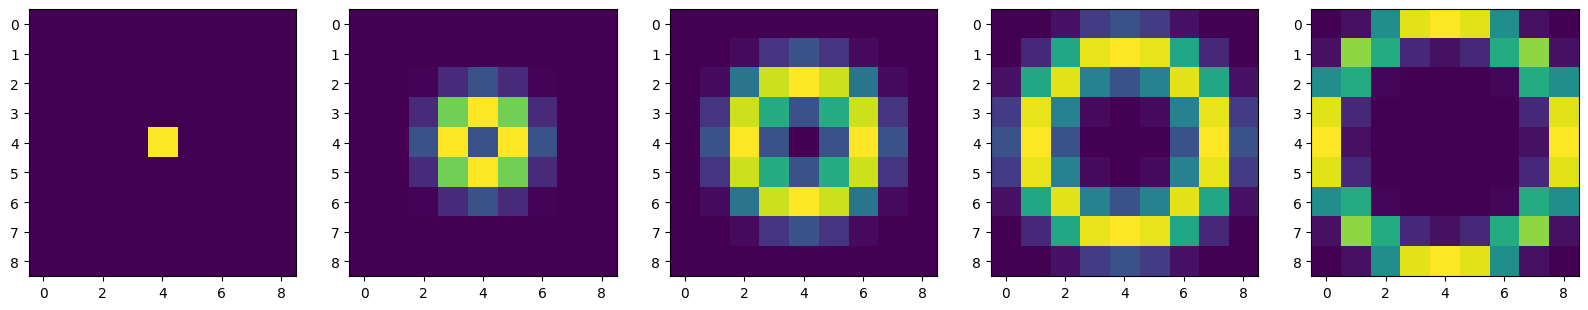

In [47]:
kernel_size = 9

# Choose the order of rotation group.
r2_act = e2cnn.gspaces.Rot2dOnR2(N = 8)

# Define the input and output representation
feat_type_in = e2cnn.nn.FieldType(r2_act, [r2_act.trivial_repr])
feat_type_hid = e2cnn.nn.FieldType(r2_act, [r2_act.trivial_repr])

# Obtain sampled basis from E2CNN
grid, basis_filter, rings, sigma, maximum_frequency = compute_basis_params(kernel_size = kernel_size)
basis = feat_type_in.gspace.build_kernel_basis(feat_type_in._unique_representations.pop(), feat_type_hid._unique_representations.pop(), sigma, rings, maximum_frequency = maximum_frequency)
block_expansion = block_basisexpansion(basis, grid, basis_filter, recompute=False).sampled_basis

print(block_expansion.shape)
# Visualize Steerable Basis
fig=plt.figure(figsize=(20, 5))
for i in range(block_expansion.shape[0]):
    fig.add_subplot(1, block_expansion.shape[0], i+1)
    plt.imshow(block_expansion[i,0,0].reshape(9,9))
plt.show()

### 3.2.2 $\rho_1 → \rho_1$

When both $\rho_{\text{in}}$ and  $\rho_{\text{out}}$ are vector representation, then the  kernel constraint for mapping of input feature map $f_\text{in}: R^2 ->R^2$ to output feature map $f_\text{out}: R^2 ->R^2$.

$$\phi(gx) = \rho_1(g)\phi(x)\rho_1(g^{-1}), g \in SO(2)$$

The kernel should have the shape of $(2, 2, k, k)$.


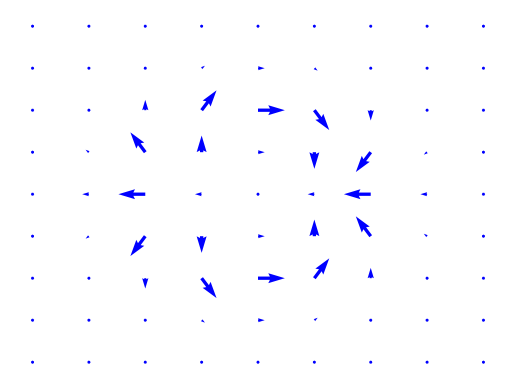

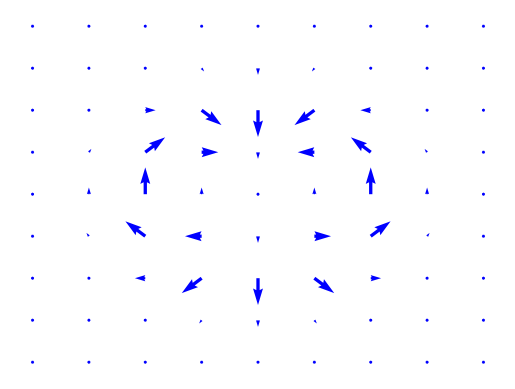

In [48]:
# Define the input and output representation
# irrep(1) corresponds to \rho_1 representation
feat_type_in = e2cnn.nn.FieldType(r2_act, [r2_act.irrep(1)])
feat_type_hid = e2cnn.nn.FieldType(r2_act, [r2_act.irrep(1)])

# Obtain sampled basis
grid, basis_filter, rings, sigma, maximum_frequency = compute_basis_params(kernel_size = kernel_size)
basis = feat_type_in.gspace.build_kernel_basis(feat_type_in._unique_representations.pop(), feat_type_hid._unique_representations.pop(), sigma, rings, maximum_frequency = maximum_frequency)
block_expansion = block_basisexpansion(basis, grid, basis_filter, recompute=False).sampled_basis

visualize_vector_field(block_expansion[7,0].reshape(2,9,9).numpy(), scale = 5)
visualize_vector_field(block_expansion[7,1].reshape(2,9,9).numpy(), scale = 5)

### 3.2.3 Equivariant Activation Functions

**Activation functions should commute with the representation of filters**
$$\sigma(\rho(h)f(x)) = \rho(h)\sigma(f(x))$$


* **Regular Representation:**  Since this action is
just permuting channels of $\rho_{reg}^G$-fields, it commutes with pointwise nonlinearities like ReLU.

* **$\rho_1$ Representation:**
We need to use norm-base activation, such as:
$$
\sigma(f(x)) = \sigma(|f(x)|) * \frac{f(x)}{|f(x)|},
$$
where $f(x)$ is feature map of vector type.

e.g. ReLU does not commute with $\rho_1$

$$\rho(R_{\pi})\text{ReLU}((1,0))=\rho(R_{\pi})(1,0) = (-1,0)$$

$$\text{ReLU}(\rho(R_{\pi})(1,0))=\text{ReLU}((-1,0)) = (0,0)$$

### 3.3.4 Irrep decomposition of the kernel constraint

Representation does not always have nice and clean forms but it can be decomposed into a direct sum of irredubile representations.

e.g.
$$\rho_{C4}(r_{\theta})
\begin{equation}
= \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & cos(\theta) & -sin(\theta) & 0 \\
0 & sin(\theta) & cos(\theta) & 0 \\
0 & 0 & 0 & cos(2\theta) \\
\end{bmatrix}
\end{equation}
$$

Decompose $\rho_{\text{out}}$ and $\rho_{\text{in}}$ in the kernel constraint $k(gx) = \rho_{\text{out}}(g) k(x) \rho_{\text{in}}(g^{-1})$ into the direct sum of irreps:

$$k(gx) = Q_{out}^{-1}[\bigoplus_{i\in I_{out}}\psi_i(g)]Q_{out}\;k(x)\;Q_{in}^{-1}[\bigoplus_{j\in I_{in}}\psi_j^{-1}(g)]Q_{in}$$

Define $\kappa(x) = Q_{out}k(x)Q_{in}^{-1}$:

$$\kappa(gx) = [\bigoplus_{i\in I_{out}}\psi_i(g)]\;\kappa(x)\;[\bigoplus_{j\in I_{in}}\psi_j^{-1}(g)]$$

Then we obtain independent constraints on block $\kappa^{ij}(x)$ in $\kappa$

$$\kappa^{ij}(gx) = \psi_i(g)\; \kappa^{ij}(x)\;\psi_j^{-1}(g)$$

![picture](https://drive.google.com/uc?export=view&id=1ceEJ5onRSYtP9WCZFSv_ZXA3yKMnaPh1)

**The kernel space constraint affects only the angular behavior of the kernels we are free to choose any radial profile. It turns out that each basis element is harmonic and associated to one unique angular frequency. Take a look at Table 2 in [E2CNN paper](https://arxiv.org/pdf/1911.08251.pdf).**

## 3.3 E2CNN and ESCNN

**With the help of [E2CNN](https://github.com/QUVA-Lab/e2cnn) & [ESCNN](https://github.com/QUVA-Lab/escnn) & [E3NN](https://e3nn.org/), constructing equivariant models has become much simpler!**






[E2CNN](https://github.com/QUVA-Lab/e2cnn) focuses on exploiting isometries, i.e. distance preserving transformations. Specifically for \mathbb{R}^2
 , the isometries are formalized by the Euclidean group  𝐸(2)
  which consists of translations, rotations and reflections

Since we are using CNNs in this tutorial, all models will be equivariant under translations. We can choose a subgroup $G\leq O(2)$ to determine the point symmetries (reflections and rotations). In the example below, we consider a the cyclic subgroup $C_4$, which models the $4$ *rotations* which are multiples of $\frac{\pi}{2}$, that is, $\big\{0, \frac{\pi}{2}, \pi, \frac{3\pi}{2}\big\}$.

We determine both the point group and its action on the space by instantiating a subclass of gspace.GSpace. For the rotational action of  𝐺=𝐶4
  on  ℝ2
  this is done by:

In [49]:
r2_act = e2cnn.gspaces.Rot2dOnR2(N = 4)
r2_act

When building an equivariant model to a group $G$, we require that the output produced by the model transforms consistently when the input transforms under the action of an element $g \in G$. We thus have to define the *field types* `feat_type_in` and `feat_type_out` of `nn.FieldType` for every layer of the network.


In [50]:
# Suppose the input is a gray-scale image
feat_type_in = e2cnn.nn.FieldType(r2_act, [r2_act.trivial_repr])

# we usually use the regular representation for middle layers.
feat_type_hid = e2cnn.nn.FieldType(r2_act, [r2_act.regular_repr])


Then we can define a convolution layer that maps trivial representation field to regular representation fields.

*Each equivariant module has an input and output type. It requires its inputs to transform according to its input type and is guaranteed to return feature fields associated with its output type.*

In [51]:
e2cnn_layer = e2cnn.nn.R2Conv(feat_type_in, feat_type_hid, kernel_size = 3, padding = 1)

Feature fields, each of its own type $\rho_l$ can be stacked: should be thought of as the channels in standard CNNs. The sub-vectors or channels in these fields live in their own sub-vector spaces $V_l$ and transform by their own representation $\rho_l$.

In [52]:
# For example, we can stack 10 regular feature fields
feat_type_hid = e2cnn.nn.FieldType(r2_act, 10* [r2_act.regular_repr])

e2cnn_layer = e2cnn.nn.R2Conv(feat_type_in, feat_type_hid, kernel_size = 3, padding = 1)

In ESCNN or E2CNN, **geometric tensors** are defined as data containers.
They wrap a *PyTorch* `torch.Tensor` to augment them with an instance of `FieldType`.

In [54]:
x = torch.randn(4, 1, 32, 32)
x = e2cnn.nn.GeometricTensor(x, feat_type_in)
# x.type

**Suppose we want to make one-step ahead prediction of ocean current velocity field given historic five frames as input.**

In [56]:
class Rot_Equiv_CNN(torch.nn.Module):
    def __init__(self,
                 input_frames, # number of input frames
                 output_frames, # number of output frames
                 hidden_dim, # hidden dimensions
                 kernel_size,
                 N # group order
                ):
        super(Rot_Equiv_CNN, self).__init__()


        # We determine both the point group and its action on the space by instantiating a subclass of gspace.GSpace
        # the model is equivariant under rotations by 90 degrees, modelled by C4
        r2_act = e2cnn.gspaces.Rot2dOnR2(N = N)

        # the input is a stack of vector fields, corresponding to the \rho_1 representation
        feat_type_in = e2cnn.nn.FieldType(r2_act, input_frames*[r2_act.irrep(1)])

        # we use the regular representation for middle layers.
        feat_type_hid = e2cnn.nn.FieldType(r2_act, hidden_dim*[r2_act.regular_repr])

        # the output is a single vector field.
        feat_type_out = e2cnn.nn.FieldType(r2_act, output_frames*[r2_act.irrep(1)])
        self.feat_type_in = feat_type_in

        # Since we use regular representation for the middle layer, we can use element-wise ReLU.
        self.model = e2cnn.nn.SequentialModule(
            e2cnn.nn.R2Conv(feat_type_in, feat_type_hid, kernel_size = kernel_size, padding = (kernel_size - 1)//2),
            e2cnn.nn.ReLU(feat_type_hid),
            e2cnn.nn.R2Conv(feat_type_hid, feat_type_hid, kernel_size = kernel_size, padding = (kernel_size - 1)//2),
            e2cnn.nn.ReLU(feat_type_hid),
            e2cnn.nn.R2Conv(feat_type_hid, feat_type_out, kernel_size = kernel_size, padding = (kernel_size - 1)//2)
        )

    def forward(self, x):
        # wrap the input tensor in a GeometricTensor
        # (associate it with the input type)
        x = e2cnn.nn.GeometricTensor(x, self.feat_type_in)

        out = self.model(x)

        # unwrap the output GeometricTensor
        # (take the Pytorch tensor and discard the associated representation)
        return out.tensor



In [ ]:
ocean_sample = torch.load("ocean_atlantic_sample.pt")
model = Rot_Equiv_CNN(input_frames = 5,
                      output_frames = 1,
                      hidden_dim = 16,
                      kernel_size = 3,
                      N = 4)

x = ocean_sample[None,:5,:,:64,:64].reshape(1,10,64,64)
out = model(x)
out.shape

*when we verify equivariance, we need to be clear about the representation of group action in the input and output spaces.*  

In [ ]:
## |rf(x) - f(rx)|
for i in range(4):
    theta = np.pi/2*i
    f_x = model(x)
    r_f_x = rot_vector(rot_img(f_x.squeeze(1), theta), theta).data.numpy()
    r_x = rot_vector(rot_img(x.squeeze(1), theta), theta)
    f_r_x = model(r_x).data.numpy()

    equiv_error = np.mean(np.abs(r_f_x - f_r_x))
    print("Equivariance Error with Rotation {:0.0f} Degrees: {:0.5f}".format(theta/np.pi/2*360, equiv_error))


Equivariance Error with Rotation 0 Degrees: 0.00000
Equivariance Error with Rotation 90 Degrees: 0.00000
Equivariance Error with Rotation 180 Degrees: 0.00000
Equivariance Error with Rotation 270 Degrees: 0.00000


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


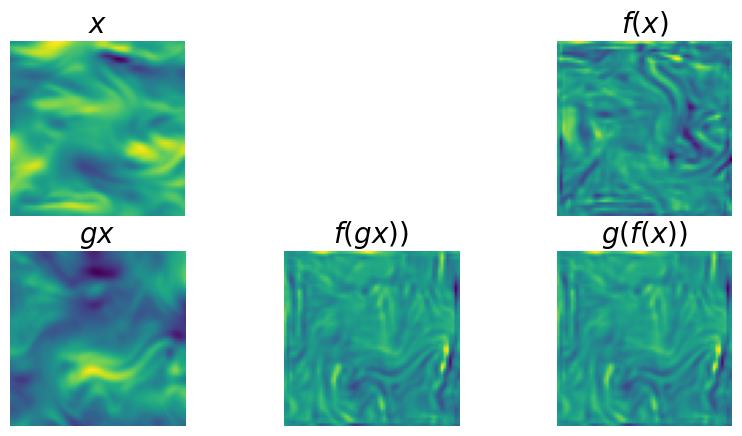

In [ ]:
titles = ["$x$", "$f(x)$", "$gx$", "$f(gx))$", "$g(f(x))$"]
vis_imgs = [x[0,0], f_x[0,0].data.numpy(), r_x[0,0].data.numpy(), f_r_x[0,0], r_f_x[0,0]]
fig=plt.figure(figsize=(10, 5))
idx = 0
for i in range(6):
    if i == 1:
        continue
    fig.add_subplot(2, 3, i+1)
    plt.imshow(vis_imgs[idx])
    plt.title(titles[idx], fontsize = 20)
    plt.axis('off')
    idx += 1
plt.show()

**Exercise: Can a C4-equivariant model able deform a square to a rectangle? Can it transform a rectangle to a square?**

In [ ]:
r2_act = e2cnn.gspaces.flipRot2dOnR2(N=8)
square_image = torch.zeros((9,9))
square_image[2,2] = 1.0
square_image[2,6] = 1.0
square_image[6,2] = 1.0
square_image[6,6] = 1.0

rect_image = torch.zeros((9,9))
rect_image[1,3] = 1.0
rect_image[1,5] = 1.0
rect_image[7,3] = 1.0
rect_image[7,5] = 1.0

# wrap images in geometric tensor
feat_type = nn.FieldType(r2_act,[r2_act.trivial_repr])

square_image_geom = nn.GeometricTensor(square_image[None,None,:,:],feat_type)
rect_image_geom = nn.GeometricTensor(rect_image[None,None,:,:],feat_type)

# 4. Physics-Guided Deep Learning for Dynamical Systems

* Rui Wang and Rose Yu; [Physics-Guided Deep Learning for Dynamical Systems: A Survey](https://arxiv.org/abs/2107.01272)

* Xuan Zhang et al. [Artificial Intelligence for Science in Quantum, Atomistic, and Continuum Systems](https://arxiv.org/abs/2307.08423)

## 4.1 Problem Formulation

Dynamical systems are mathematical objects that are used to describe the evolution of phenomena over time and space occurring in nature. Dynamical systems are commonly described with differential equations which are equations related to one or more unknown functions and their derivatives.

**Definition**: Fix an integer $k \geq 1$ and let $U$ denote an open subset of $\mathbb{R}^n$. Let $u: U \mapsto \mathbb{R}^m$ and we write ${u} = (u^1, ..., u^m)$, where $x \in U$. Then an expression of the form

$$F(D^k {u}(x), D^{k-1} {u}(x), ..., D{u}(x), {u}(x), x) = 0$$

is called a $k^{\text{-th}}$-order system of partial differential equation (or ordinary differential equation when $n=1$), where $F: \mathbb{R}^{mn^k}\times \mathbb{R}^{mn^{k-1}}\times...\times\mathbb{R}^{mn}\times \mathbb{R}^{m}\times U \mapsto \mathbb{R}^m $.


### 4.1.1 Solving Differential Equations
When $F$ is *known* but too complicated to be solvable, researchers tend to directly solve the differential Eq.ations by approximating solution of ${u}(x)$ with a deep neural network, and enforcing the governing equations as a soft constraint on the output of the neural nets during training at the same time. This approach can be formulated as the following optimization problem,

$$\text{min}_{\theta} \; {L}({u}) + \lambda_{F}{L}_{F}({u})$$

$L({u})$ denotes the misfit of neural net predictions and the training data points. $\theta$ denotes the neural net parameters. ${L}_{F}({u})$ is a constraint on the residual of the differential equation system under consideration.


* Maziar Raissi et al. [Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations](https://www.sciencedirect.com/science/article/pii/S0021999118307125)


### 4.1.2 Learning Dynamics Residuals
When $F$ is *partially known*, we can use neural nets to learn the errors or residuals made by physics-based models. The key is to learn the bias of physics-based models and correct it with the help of deep learning. The final prediction of the state is composed of the simulation from the physics-based models and the residual prediction from neural nets as below,

$$\hat{u} = \hat{u}_{F} + \hat{u}_{\text{NN}}.$$

where $\hat{u}_{F}$ is the prediction obtained by numerically solving ${F}$, $\hat{u}_{\text{NN}}$is the prediction from neural networks and $\hat{u}$ is the final prediction made by hybrid physics-DL models.


* Yuan Yin et al. [Augmenting Physical Models with Deep Networks for Complex Dynamics Forecasting](https://arxiv.org/abs/2010.04456)

* Filipe de Avila Belbute-Peres et al. [Combining Differentiable PDE Solvers and Graph Neural Networks for Fluid Flow Prediction](https://arxiv.org/abs/2007.04439)

### 4.1.3 Dynamics Forecasting
When ${F}$ is *unknown* or numerically solving it requires too much computation, many works studied learning high-dimensional spatiotemporal dynamics by directly predicting the input-output system state mapping and bypassing numerical discretization and integration. If we assume the first dimension $x_1$ of ${u}$ is the time dimension $t$, then the problem of dynamics forecasting can be defined as learning a map $f: \mathbb{R}^{n \times k} \mapsto \mathbb{R}^{n \times q} $ that maps a sequence of historic states to future states of the dynamical system,

$$f({u}(t-k+1, \cdot), ..., {u}(t, \cdot)) = {u}(t+1, \cdot), ..., {u}(t+q, \cdot)$$
where $k$ is the input length and $q$ is the output length. $f$ is commonly approximated with purely data-driven or physics-guided neural nets and the neural nets are optimized by minimizing the prediction errors of the state ${L}({u})$.




* Tobias Pfaff et al. [Learning mesh-based simulation with graph networks.](https://arxiv.org/abs/2010.03409)
* Emmanuel de Bezenac et al. [Deep learning for physical
processes: Incorporating prior scientific knowledge.](https://arxiv.org/abs/1711.07970)

### 4.1.4 Search for Governing Equations
When ${F}$ is *unknown* and it is necessary to determine the precise governing equations to solve practical problems, numerous efforts have been made to discover the exact mathematical formulation of ${F}$. The most common approach is to select from a wide range of possible candidate functions and choose the model that minimizes fitting errors on observation data.

More specifically,the goal of discovering governing equations is to find an approximate function $\hat{F} = \Phi({u}(x), x) \boldsymbol{\theta} \approx {F}$, where $\Phi({u}(x), x) = [\phi_1({u}(x), x), \phi_2({u}, x), \ldots, \phi_p({u}, x)]$ is a library of candidate functions, such as polynomials and trigonometric functions, and $\boldsymbol{\theta} \in \mathbb{R}^p$ is a sparse vector indicating which candidate functions are active in the dynamics. This problem can be formulated as an optimization problem, where we aim to minimize the following cost function over a set of observed data $\{{y}_i\}_{i=1}^n$ of ${u}$:

$${L}(\boldsymbol{\theta}) = \sum_{i=1}^n ||\Phi({y}_i, x) \boldsymbol{\theta}||^2 $$

* Subham Sahoo et al. [Learning equations for extrapolation
and control.](https://arxiv.org/abs/1806.07259)

* Steven L. Brunton et al. [Discovering governing equations from data: Sparse identification of nonlinear dynamical systems](https://arxiv.org/abs/1509.03580)

## 4.2 Long term robust forecasting

Suppose we are using a MLP to forecast low-dimensional dynamics.

In [61]:
class MLP(nn.Module):
  def __init__(self, input_dim, input_length, output_dim, output_length, hidden_dim):
    super().__init__()

    self.output_length = output_length
    self.output_dim = output_dim
    self.model = nn.Sequential(
        nn.Linear(input_dim*input_length, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, output_dim*output_length),
        )

  def forward(self, inps):
    # expected input dims (batch size, sequence length, number of features)
    inps = inps.reshape(inps.shape[0], -1)

    # reshape it to (batch size, sequence length, number of features)
    return self.model(inps).reshape(inps.shape[0], self.output_length, self.output_dim)

### 4.2.1 Autogressive Rollout vs. Direct Mapping vs. Temperal Bundling

**Autoregressive Rollout:** Make one-step prediction at a time and predict the full rollout by applying the trained network autoregressively $𝑇$ times.

In [62]:
input_length = 8
output_length = 10
feat_dim = 3

model = MLP(input_dim = feat_dim,
            input_length = input_length,
            output_dim = feat_dim,
            output_length = 1, # make one-step ahead prediction
            hidden_dim = 16)

loss = 0
preds = []
loss_fun = torch.nn.MSELoss()
x = torch.randn(1, input_length, feat_dim)
y = torch.randn(1, output_length, feat_dim)
for i in range(output_length):
    pred = model(x)
    x = torch.cat([x[:, 1:], pred], dim = 1)
    loss += loss_fun(pred, y[:,i:i+1])
    preds.append(pred)
total_pred = torch.cat(preds, dim = 1)

**Direct Mapping:** Learn a function that directly map history to all future $T$ steps.

In [ ]:
model = MLP(input_dim = feat_dim,
            input_length = input_length,
            output_dim = feat_dim,
            output_length = output_length,
            hidden_dim = 16)

total_pred = model(x)
loss = loss_fun(total_pred, y)

**Temporal bundling[(Link to the paper)](https://arxiv.org/pdf/2202.03376.pdf):** the model generates multiple steps in each autoregressive call, to reduce number of solver calls and therefore error propagation speed.

In [63]:
input_length = 8
output_length = 10
feat_dim = 3
num_steps_per_call = 2

model = MLP(input_dim = feat_dim,
            input_length = input_length,
            output_dim = feat_dim,
            output_length = num_steps_per_call,
            hidden_dim = 16)

loss = 0
preds = []
loss_fun = torch.nn.MSELoss()
for i in range(output_length//num_steps_per_call):
    pred = model(x)
    x = torch.cat([x[:, num_steps_per_call:], pred], dim = 1)
    loss += loss_fun(pred, y[:,i*num_steps_per_call:(i+1)*num_steps_per_call])
    preds.append(pred)
total_pred = torch.cat(preds, dim = 1)

### 4.2.2 Reversible Instance Normalization [(Link to the paper)](https://openreview.net/forum?id=cGDAkQo1C0p)

In [64]:
class RevIN(nn.Module):
  """Reinversible instance normalization.

  Attributes:
    num_features: the number of features or channels
    eps: a value added for numerical stability
    axis: axis to be normalized
    affine: if True, RevIN has learnable affine parameters
  """
  def __init__(self, num_features, eps=1e-5, affine=False, axis=1):
    super().__init__()
    self.num_features = num_features
    self.eps = eps
    self.axis = axis
    self.affine = affine
    if self.affine:
      self.init_params()

  def forward(self, x, mode):
    """Apply normalization or inverse normalization.

    Args:
      x: input ts
      mode: normalize or denormalize

    Returns:
      nomarlized or denormalized x

    Raises:
      NotImplementedError:
    """

    if mode == "norm":
      self.get_statistics(x)
      x = self.normalize(x)
    elif mode == "denorm":
      x = self.denormalize(x)
    else:
      raise NotImplementedError
    return x

  def init_params(self):
    # initialize RevIN params:
    self.affine_weight = nn.Parameter(torch.ones(1, 1, self.num_features))
    self.affine_bias = nn.Parameter(torch.zeros(1, 1, self.num_features))

  def get_statistics(self, x):
    self.mean = torch.mean(x, dim=self.axis, keepdim=True)
    self.stdev = torch.sqrt(torch.std(x, dim=self.axis, keepdim=True) + self.eps)

  def normalize(self, x):
    x = x - self.mean
    x = x / self.stdev
    if self.affine:
      x = x * self.affine_weight
      x = x + self.affine_bias
    return x

  def denormalize(self, x):
    if self.affine:
      x = x - self.affine_bias
      x = x / (self.affine_weight + self.eps * self.eps)
    x = x * self.stdev
    x = x + self.mean
    return x

In [65]:
model = MLP(input_dim = feat_dim,
            input_length = input_length,
            output_dim = feat_dim,
            output_length = 1,
            hidden_dim = 16)

loss = 0
preds = []
loss_fun = torch.nn.MSELoss()
normalizer = RevIN(num_features=feat_dim, axis=(1, 2))

x = torch.randn(1,input_length,feat_dim)
y = torch.randn(1,output_length,feat_dim)
for i in range(output_length):

    # First normalize the input
    norm_inp = normalizer.forward(x, mode="norm")
    norm_pred = model(norm_inp)
    norm_tgt = normalizer.normalize(y[:,i:i+1])
    loss += loss_fun(norm_pred, norm_tgt)

    # Denormalize the prediction and add it back to the input for autoregressive call.
    pred = normalizer.forward(norm_pred, mode="denorm")
    x = torch.cat([x[:, 1:], pred], dim = 1)
    preds.append(pred)
total_pred = torch.cat(preds, dim = 1)

### 4.2.3 Noise Injection

* Tobias Pfaff et al. [Learning mesh-based simulation with graph networks.](https://arxiv.org/abs/2010.03409)

Suppose the current position $x_t = 2$ and we need to predict $x_{t+1} = 3$. We add noise to $x_t$ ($x^*_t = 2.1$) and  train the model the predict the velocity instead of positions, then the target velocity $\dot{x_t} = 1$ will be adjusted to $\dot{x^*_t} = 0.9$, so that integration, the model prediction $\hat{x_{t+1}} = 2.1 + 0.9$ matches $x_{t+1}$.

In [66]:
input_length = 8
output_length = 10
feat_dim = 1

model = MLP(input_dim = feat_dim,
            input_length = input_length,
            output_dim = feat_dim,
            output_length = 1,
            hidden_dim = 16)

loss = 0
preds = []
loss_fun = torch.nn.MSELoss()
x = torch.randn(1,input_length,feat_dim)
y = torch.randn(1,output_length,feat_dim)
vel_y = torch.diff(torch.cat([x[:,-1:], y], dim = 1), dim = 1)

In [67]:
for i in range(output_length):
    # add noise to last input step
    noise = np.random.normal(0, feat_dim)
    x[...,-1] += noise

    # Predictint velocity instead of acceleration.
    pred_vel = model(x)

    #velocity_adj = x_{t+1} - (x_{t} + noise)
    loss += loss_fun(pred_vel, vel_y[:,i:i+1] - noise)

    pred = pred_vel + x[:, -1:]
    x = torch.cat([x[:, 1:], pred], dim = 1)
    preds.append(pred)
total_pred = torch.cat(preds, dim = 1)